In [237]:
import pygsti
from pygsti.circuits import Circuit
import random
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from pygsti.tools.lindbladtools import *
from pygsti.baseobjs.basisconstructors import id2x2, sigmax, sigmay, sigmaz
from pygsti.modelmembers.operations import LindbladErrorgen
from tqdm import tqdm
SigX = np.array([[0, 1], [1, 0]], dtype=complex)
SigY = np.array([[0, -1j], [1j, 0]], dtype=complex)
SigZ = np.array([[1, 0], [0, -1]], dtype=complex)

In [273]:
class Point():
    """
    A point on a manifold
    
    Contains: 
        a vector of sympy variables 
        a descriptor of every parameter (elementary egen label + supporting gate(s))
        a basis matrix generator function
        a dual basis matrix generator function
    """
    def __init__(self, descriptors=None, symbols=None):
        self.descriptors = descriptors
        if symbols not None:
            self.symbols = symbols
        elif descriptors not None:
            self.
        
    

SyntaxError: invalid syntax (3639017118.py, line 13)

In [238]:
import numpy as _np
import scipy.sparse as _sps

from pygsti.tools import matrixtools as _mt
from pygsti.tools.basistools import basis_matrices

In [239]:
def create_elementary_errorgen_pp(typ, p, q=None, sparse=False):
    """
    Construct an elementary error generator as a matrix in the "pauli product" basis.
    There are four different types of elementary error generators: 'H' (Hamiltonian),
    'S' (stochastic), 'C' (correlation), and 'A' (active).  See arxiv:2103.01928.
    Each type transforms an input density matrix differently.  The action of an elementary
    error generator `L` on an input density matrix `rho` is given by:
    Hamiltonian:  `L(rho) = -1j * [ p, rho ]`
    Stochastic:   `L(rho) = p * rho * p - rho
    Correlation:  `L(rho) = p * rho * q + q * rho * p - 0.5 {{p,q}, rho}
    Active:       `L(rho) = 1j( p * rho * q - q * rho * p + 0.5 {[p,q], rho} )
    Square brackets denotes the commutator and curly brackets the anticommutator.
    `L` is returned as a superoperator matrix that acts on vectorized density matrices.
    Parameters
    ----------
    typ : {'H','S','C','A'}
        The type of error generator to construct.
    p : numpy.ndarray
        d-dimensional basis matrix.
    q : numpy.ndarray, optional
        d-dimensional basis matrix; must be non-None if and only if `typ` is `'C'` or `'A'`.
    sparse : bool, optional
        Whether to construct a sparse or dense (the default) matrix.
    Returns
    -------
    ndarray or Scipy CSR matrix
    """
    d = p.shape[0]; d2 = d**2
    if sparse:
        elem_errgen = _sps.lil_matrix((d2, d2), dtype=p.dtype)
    else:
        elem_errgen = _np.empty((d2, d2), dtype=p.dtype)

    assert(typ in ('H', 'S', 'C', 'A')), "`typ` must be one of 'H', 'S', 'C', or 'A'"
    assert((typ in 'HS' and q is None) or (typ in 'CA' and q is not None)), \
        "Wrong number of basis elements provided for %s-type elementary errorgen!" % typ

    pdag = p.T.conjugate()
    qdag = q.T.conjugate() if (q is not None) else None

    if typ in 'CA':
        pq_plus_qp = pdag @ q + qdag @ p
        pq_minus_qp = pdag @ q - qdag @ p

    # Loop through the standard basis as all possible input density matrices
    for i, rho0 in enumerate(basis_matrices('std', d2)):  # rho0 == input density mx
        # Only difference between H/S/C/A is how they transform input density matrices
        if typ == 'H':
            rho1 = -1j * (p @ rho0 - rho0 @ p)  # Add "/2" to have PP ham gens match previous versions of pyGSTi
        elif typ == 'S':
            pdag_p = (pdag @ p)
            rho1 = p @ rho0 @ pdag - 0.5 * (pdag_p @ rho0 + rho0 @ pdag_p)
        elif typ == 'C':
            rho1 = p @ rho0 @ qdag + q @ rho0 @ pdag - 0.5 * (pq_plus_qp @ rho0 + rho0 @ pq_plus_qp)
        elif typ == 'A':
            rho1 = 1j * (p @ rho0 @ qdag - q @ rho0 @ pdag + 0.5 * (pq_minus_qp @ rho0 + rho0 @ pq_minus_qp))

        elem_errgen[:, i] = rho1.flatten()[:, None] if sparse else rho1.flatten()

    if sparse: elem_errgen = elem_errgen.tocsr()
    return np.round(pygsti.tools.change_basis(elem_errgen, 'std', 'pp'), 12)

def create_elementary_errorgen_dual_pp(typ, p, q=None, sparse=False, normalization_factor='auto'):
    """
    Construct a "dual" elementary error generator matrix in the "pauli product"  basis.
    The elementary error generator that is dual to the one computed by calling
    :function:`create_elementary_errorgen` with the same argument.  This dual element
    can be used to find the coefficient of the original, or "primal" elementary generator.
    For example, if `A = sum(c_i * E_i)`, where `E_i` are the elementary error generators given
    by :function:`create_elementary_errorgen`), then `c_i = dot(D_i.conj(), A)` where `D_i`
    is the dual to `E_i`.
    There are four different types of dual elementary error generators: 'H' (Hamiltonian),
    'S' (stochastic), 'C' (correlation), and 'A' (active).  See arxiv:2103.01928.
    Each type transforms an input density matrix differently.  The action of an elementary
    error generator `L` on an input density matrix `rho` is given by:
    Hamiltonian:  `L(rho) = -1j/(2d^2) * [ p, rho ]`
    Stochastic:   `L(rho) = 1/(d^2) p * rho * p
    Correlation:  `L(rho) = 1/(2d^2) ( p * rho * q + q * rho * p)
    Active:       `L(rho) = 1j/(2d^2) ( p * rho * q - q * rho * p)
    where `d` is the dimension of the Hilbert space, e.g. 2 for a single qubit.  Square
    brackets denotes the commutator and curly brackets the anticommutator.
    `L` is returned as a superoperator matrix that acts on vectorized density matrices.
    Parameters
    ----------
    typ : {'H','S','C','A'}
        The type of dual error generator to construct.
    p : numpy.ndarray
        d-dimensional basis matrix.
    q : numpy.ndarray, optional
        d-dimensional basis matrix; must be non-None if and only if `typ` is `'C'` or `'A'`.
    sparse : bool, optional
        Whether to construct a sparse or dense (the default) matrix.
    Returns
    -------
    ndarray or Scipy CSR matrix
    """
    d = p.shape[0]; d2 = d**2
    pdag = p.T.conjugate()
    qdag = q.T.conjugate() if (q is not None) else None

    if sparse:
        elem_errgen = _sps.lil_matrix((d2, d2), dtype=p.dtype)
    else:
        elem_errgen = _np.empty((d2, d2), dtype=p.dtype)

    assert(typ in ('H', 'S', 'C', 'A')), "`typ` must be one of 'H', 'S', 'C', or 'A'"
    assert((typ in 'HS' and q is None) or (typ in 'CA' and q is not None)), \
        "Wrong number of basis elements provided for %s-type elementary errorgen!" % typ

    # Loop through the standard basis as all possible input density matrices
    for i, rho0 in enumerate(basis_matrices('std', d2)):  # rho0 == input density mx
        # Only difference between H/S/C/A is how they transform input density matrices
        if typ == 'H':
            rho1 = -1j * (p @ rho0 - rho0 @ p)  # -1j / (2 * d2) *
        elif typ == 'S':
            rho1 = (p @ rho0 @ pdag)  # 1 / d2 *
        elif typ == 'C':
            rho1 = (p @ rho0 @ qdag + q @ rho0 @ pdag)  # 1 / (2 * d2) *
        elif typ == 'A':
            rho1 = 1j * (p @ rho0 @ qdag - q @ rho0 @ pdag)  # 1j / (2 * d2)
        elem_errgen[:, i] = rho1.flatten()[:, None] if sparse else rho1.flatten()

    return_normalization = bool(normalization_factor == 'auto_return')
    if normalization_factor in ('auto', 'auto_return'):
        primal = create_elementary_errorgen(typ, p, q, sparse)
        if sparse:
            normalization_factor = _np.vdot(elem_errgen.toarray().flatten(), primal.toarray().flatten())
        else:
            normalization_factor = _np.vdot(elem_errgen.flatten(), primal.flatten())
    elem_errgen *= _np.real_if_close(1 / normalization_factor).item()  # item() -> scalar
    elem_errgen = np.round(pygsti.tools.change_basis(elem_errgen, 'std', 'pp'), 12)

    if sparse: elem_errgen = elem_errgen.tocsr()
    return (elem_errgen, normalization_factor) if return_normalization else elem_errgen

In [240]:
def pstr_to_mat(pstr):
    pmat = 1
    for pchar in pstr:
        if pchar == 'X':
            pmat = np.kron(pmat, SigX)
        elif pchar == 'Y':
            pmat = np.kron(pmat, SigY)
        elif pchar == 'Z':
            pmat = np.kron(pmat, SigZ)
        else:
            pmat = np.kron(pmat, np.array([[1, 0], [0, 1]], dtype=complex))
    return pmat

def egenlbl_to_mat(lbl, num_qubits):
    egen_type = lbl.errorgen_type
    egen_basis_lbls = lbl.basis_element_labels
    egen_support = lbl.support
    # convert the basis labels into Pauli strings
    pstr1 = ['I']*num_qubits
    for i, pchar in enumerate(egen_basis_lbls[0]):
        pstr1[egen_support[i]] = pchar
    pstr1 = ''.join(pstr1)
    pmat1 = pstr_to_mat(pstr1)
    if egen_type in 'CA':
        pstr2 = ['I']*num_qubits
        for i, pchar in enumerate(egen_basis_lbls[1]):
            pstr2[egen_support[i]] = pchar
        pstr2 = ''.join(pstr2)
        pmat2 = pstr_to_mat(pstr2)
        return create_elementary_errorgen_pp(egen_type, pmat1, pmat2)
    else:
        return create_elementary_errorgen_pp(egen_type, pmat1)
    
def egenlbl_to_dual(lbl, num_qubits):
    egen_type = lbl.errorgen_type
    egen_basis_lbls = lbl.basis_element_labels
    egen_support = lbl.support
    # convert the basis labels into Pauli strings
    pstr1 = ['I']*num_qubits
    for i, pchar in enumerate(egen_basis_lbls[0]):
        pstr1[egen_support[i]] = pchar
    pstr1 = ''.join(pstr1)
    pmat1 = pstr_to_mat(pstr1)
    if egen_type in 'CA':
        pstr2 = ['I']*num_qubits
        for i, pchar in enumerate(egen_basis_lbls[1]):
            pstr2[egen_support[i]] = pchar
        pstr2 = ''.join(pstr2)
        pmat2 = pstr_to_mat(pstr2)
        return create_elementary_errorgen_dual_pp(egen_type, pmat1, pmat2)
    else:
        return create_elementary_errorgen_dual_pp(egen_type, pmat1)

In [241]:
# dual basis returns a negative rate ???
print(np.trace(create_elementary_errorgen_pp('A', SigZ, SigX)@create_elementary_errorgen_dual_pp('A', SigZ, SigX)))
# seems to work for conjugate of the dual
print(np.trace(create_elementary_errorgen_pp('A', SigZ, SigX).conj().T@create_elementary_errorgen_dual_pp('A', SigZ, SigX)))

-1.0
1.0


In [367]:
class ErrorGen():
    """
    Implements the small Markovian taxonomy
    
    Parameters:
        -features: pauli transfer representations for different error processes
        -rates: sympy vector of rates
    """
    
    def __init__(self, num_qubits, gate_label=('G', 0), parameterization='HSCA'):
        """
        setup the feature dictionary with keys that are sympy variables
        
        right now, I'm doing this by hand for a 1 qubit model, 
        """
        self.num_qubits = num_qubits
        self.feature_map = dict() # maps params (sp variables) to corresponding basis 
        self.label_map = dict() # maps params to corresponding pygsti labels
        self.labels =  LindbladErrorgen.from_error_generator(4**num_qubits).coefficient_labels()
        self.params = []
        for lbl in self.labels:
            if len(lbl.basis_element_labels) > 1:
                pstr = lbl.basis_element_labels[0] + 'x' + lbl.basis_element_labels[1]
                pmat1 = pstr_to_mat(lbl.basis_element_labels[0])
                pmat2 = pstr_to_mat(lbl.basis_element_labels[1])
            else:
                pstr = lbl.basis_element_labels[0]
                pmat = pstr_to_mat(lbl.basis_element_labels[0])
            if len(gate_label) > 1:
                gstr = str(gate_label[0]) + 'q' + str(gate_label[1])
            else:
                gstr = gate_label[0]
            param = sp.symbols(f'{{{lbl.errorgen_type}}}^{{{pstr}}}_{{{gstr}}} ')
            self.params.append(param)
            self.label_map[param] = lbl
            self.feature_map[param] = egenlbl_to_mat(lbl, num_qubits)
    
            
    @property
    def vec(self):
        return list(self.params)
    
    @property
    def mat(self):
        mat = np.zeros((4**self.num_qubits, 4**self.num_qubits), dtype='O')
        for x in self.vec:
            mat += x*self.feature_map[x]
        return sp.Matrix(mat)
    
    @property
    def features(self):
        return [f for f in self.feature_map.values()]
    
    @property
    def dual_features(self):
        return [egenlbl_to_dual(lbl, self.num_qubits) for lbl in self.labels]
    
    def extract_rates(self):
        rates = dict()
        gen = self.mat
        for lbl in tqdm(self.labels):
            dgen = egenlbl_to_dual(lbl, self.num_qubits)
            rates[lbl] = np.trace(dgen.conj().T@gen)
        return rates
        

In [270]:
class GateSet():
    """
    Holds the information for
        -all native gates, states, and measurements
        -all error generator features (in a feature dict)
        -map between gate labels and parameter index list (index set)
        -map between parameter indices and error features (feature dict) 
        
    TODO: generalize to n-qubits
    """
    def __init__(self, model_pack):
        # A list of error rates, each one corresponding to one feature in the above list
        self.rates = []
        self.gate_errors = dict() # maps gate parameters to error generators
        self.feature_map = dict() # maps variables to their associated feature
        self.target_model = model_pack.target_model('CPTP')
        self.gate_labels = model_pack.gates
        self.num_qubits = model_pack.processor_spec().num_qubits
        
        # Errors generators for all gates in the model
        for gate in model_pack.gates:
            if len(gate) <= 1:
                egen = ErrorGen(self.num_qubits, (gate, ''))
            else:
                egen = ErrorGen(self.num_qubits, gate)
            self.gate_errors[gate] = egen
            self.rates += egen.vec
            self.feature_map.update({p : egen.feature_map[p] for p in egen.vec})
        # Errors for all measurements in the model
        for povm in self.target_model.povms.keys():
            egen = ErrorGen(self.num_qubits, (povm, 'M'))
            self.gate_errors[povm] = egen
            self.rates += egen.vec
            self.feature_map.update({p : egen.feature_map[p] for p in egen.vec})
        # Errors for all state preparations in the model
        for prep in self.target_model.preps.keys():
            egen = ErrorGen(self.num_qubits, (prep, 'P'))
            self.gate_errors[prep] = egen
            self.rates += egen.vec
            self.feature_map.update({p : egen.feature_map[p] for p in egen.vec})
            
    @property
    def vec(self):
        return self.rates
    
    @property
    def num_params(self):
        return len(self.vec)
    
    def features_of(self, op_label):
        """Returns the list of error features associated with the given gate/POVM/state-prep"""
        return self.gate_errors[op_label].features
    
    def rates_of(self, op_label):
        """Returns the list of error rates associated with the given gate/POVM/state-prep"""
        return self.gate_errors[op_label].vec
    
    def error_matrix_of(self, op_label):
        """Returns the error generator matrix associated with the given gate/POVM/state-prep"""
        return self.gate_errors[op_label].mat
    
    def target_op(self, op_label):
        """
        returns the target operation of the given operation
        """
        return self.target_model[op_label].to_dense()

    def native_meas(self):
        return [m.to_dense() for m in self.target_model['Mdefault'].values()]

    def rho0(self):
        return self.target_model['rho0'].to_dense()

A gate:
$$
    G(a) = e^{x^i L_i(a)} U(a)
$$

A circuit
$$
    C = \prod_{i = 1}^n G(g_i) = \prod_{i = 1}^n e^{x^i L_i(g_i)} U(g_i)
$$

A circuit factorization
$$
    C = \Bigg( \prod_{i = 1}^n e^{x^i L_i'(g_i)} \Bigg) \times \Bigg( \prod_{i = 1}^n  U(g_i) \Bigg)
$$
where 
$$
    L_i'(c_i) = \bigg( \prod_{j > i } U(g_i) \bigg) L_i(g_i) \bigg( \prod_{j > i } U(g_i) \bigg)^{-1}.
$$

Now, define a sparse representation of the gate set errors with the formal equivalence
$$
    z^i =  \langle L^i, x^j L_j \rangle. 
$$

Then, conjugation corresponds to a linear transformation on $z$:
$$
    R(U) z \equiv x^j U L_j U^{-1}
$$

We may define $R(U)$ coordinate-wise per 
$$
    R(U)_{j}^i = \langle L^i, U L_j U^{-1} \rangle
$$

In [422]:
class CircuitAnalyzer():
    def __init__(self, gateset : GateSet):
        self.gateset = gateset
        
    def left_errors(self, circ):
        emaps = []
        adjoints = dict()
        for 
            
        
        
    def left_conjugators(self, circ, error_basis):
        # [1] calculate all the adjoint operators of all the gates
        left_errors = []
        adjoints = dict()
        for gate in self.gateset.gate_labels:
            adjoints[gate] = self._adjoint_operator(self.gateset.target_op(gate), error_basis)
        # [2] construct the conjugators
        conjugators = []
        conjugators.append(np.eye(list(adjoints.values())[0].shape[0]))
        for i in range(len(circ)-1, 0, -1):
            conjugators.append(adjoints[circ[i]]@conjugators[len(circ)-i-1])
        return conjugators
    
        
    def _adjoint_operator(self, conj_unitary, error_gen):
        """
        
        """
        R = np.zeros((len(error_gen.vec), len(error_gen.vec)))
        for i, di_dual in enumerate(error_gen.dual_features):
            for j, pj in enumerate(error_gen.features):
                R[i, j] = np.trace(di_dual@conj_unitary@pj@np.conj(conj_unitary.T))
        return R

In [392]:
from pygsti.modelpacks import smq2Q_XYCPHASE as std
from pygsti.modelpacks import smq1Q_XYI as std


In [402]:
gs = GateSet(std)
params = gs.vec
len(params)

60

In [430]:
error_basis = ErrorGen(1, ('std_basis'))

In [431]:
ca = CircuitAnalyzer(gs)
circ = Circuit([('Gxpi2', 0), ('Gypi2', 0)])

In [432]:
conjugators = ca.left_conjugators(circ, error_basis)

In [433]:
gs.gate_errors.keys()

dict_keys([(), ('Gxpi2', 0), ('Gypi2', 0), Label('Mdefault'), Label('rho0')])

In [434]:
gate = ('Gypi2', 0)
egen = gs.gate_errors[gate]

In [440]:
R = ca._adjoint_operator(gs.target_op(('Gypi2', 0)), error_basis)

In [441]:
R.shape

(12, 12)

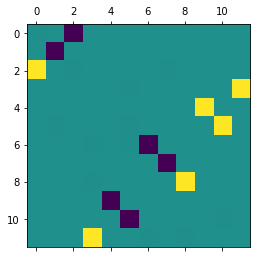

In [437]:
plt.matshow(R)

In [439]:
for g in gs.gate_labels:
    print(np.linalg.matrix_rank(ca._adjoint_operator(gs.target_op(g), error_basis)))

12
12
12


# The matrix derivative of the exponential of an error generator is 
$$
    \frac{d}{dt} e^{X(t)} = e^{X(t)}  [\frac{I - e^{-\text{ad}_{X(t)}} }{\text{ad}_{X(t)}} ] ( \frac{dX}{dt} )
$$

Define
$$ 
    \Delta (X(t)) = [\frac{I - e^{-\text{ad}_{X(t)}} }{\text{ad}_{X(t)}} ] ( \frac{dX}{dt} ) \approx \frac{dX}{dt} - \frac{1}{2} [X(t), \frac{dX}{dt}] + O[X(t)]^2
$$